In [13]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gamma, multivariate_normal
import data, random

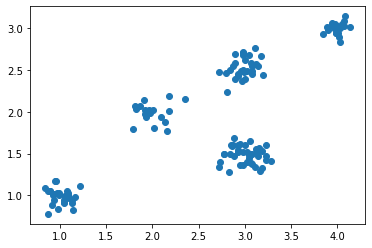

In [26]:
centers_x = [1, 2,   3,   3, 4]
centers_y = [1, 2, 1.5, 2.5, 3]
covs = [np.array([[1, 0],[0, 1]]), 
        np.array([[2, 0.3],[0.3, 1]]),
        np.array([[2, -0.3],[-0.3, 1]]),
        np.array([[1, 0.3],[0.3, 2]]), 
        np.array([[0.5, 0.1],[0.1, 0.5]])]
datanums = [30, 20, 40, 30, 20]

data = []

for i in range(5):
    p = multivariate_normal((centers_x[i], centers_y[i]), covs[i]/100)
    data.extend(p.rvs(datanums[i]))
    
random.shuffle(data)
#print(data)

plt.scatter([x for (x,y) in data], [y for (x,y) in data])
    


In [33]:
K = 10

def initial_r(data):
    rs = []
    for i,d in enumerate(data):
        r = [0]*K
        r[i%10] = 1.0
        
        rs.append(r)
        
    return rs

In [35]:
rs = initial_r(data)

In [51]:
def weighted_num(k, rs):
    return sum([r[k] for r in rs])

def weighted_mean(k, rs, data):
    return sum([ r[k]*p for (r, p) in zip(rs, data)])/weighted_num(k, rs)
    

In [52]:
ns = [weighted_num(k, rs) for k in range(K)]
xs = [weighted_mean(k, rs, data) for k in range(K)]

In [55]:
print(ns)
print(xs)

[14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0]
[array([2.88358209, 2.15925516]), array([2.755317  , 1.89610709]), array([2.27589045, 1.53423761]), array([2.67141523, 1.89316013]), array([2.61443018, 1.83053952]), array([2.77106032, 1.95388671]), array([2.23624185, 1.78912943]), array([2.38838299, 1.84910903]), array([2.58337079, 2.01341653]), array([2.50853733, 1.99385704])]
